In [1]:
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

### Data Preperation

In [4]:
# Define transformations for training and testing data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
# Load the CIFAR-10 dataset
batch_size = 64
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
results = []

## Solution: Basic Neural Network

In [7]:
num_epochs = 20
learning_rate = 0.001

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
model = NeuralNetwork().to(device)

# Training Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 10
start_time = time.time()

# Ensure inputs and labels are moved to the same device as the model
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to device
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nTraining Finisehd, time: {elapsed_time:.2f} seconds")

Epoch 1, Loss: 1.8130785510363177
Epoch 2, Loss: 1.6583778495373933
Epoch 3, Loss: 1.5928010789634626
Epoch 4, Loss: 1.5598207219787266
Epoch 5, Loss: 1.5309036180491338
Epoch 6, Loss: 1.5091679257809962
Epoch 7, Loss: 1.4912994040552612
Epoch 8, Loss: 1.4710236883834196
Epoch 9, Loss: 1.4599549082843848
Epoch 10, Loss: 1.4492893671745535

Training Finisehd, time: 110.41 seconds


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")
results.append(dict(name="NN", accuracy=(100 * correct / total), epochs=num_epochs, learning_rate=learning_rate))


Accuracy on test set: 48.25%


In [12]:
del model

In [13]:
torch.cuda.empty_cache() # after each model finishes training to free up GPU memory

## Case: Convolutional Neural Network (CNN)

In [14]:
# settings
num_epochs = 20
learning_rate = 0.001

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
model = SimpleCNN().to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")


end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nTraining Finisehd, time: {elapsed_time:.2f} seconds")


Epoch 1, Loss: 1.5016195748163306
Epoch 2, Loss: 1.105369296677582
Epoch 3, Loss: 0.9338339286692002
Epoch 4, Loss: 0.8450944603937666
Epoch 5, Loss: 0.7831570894059623
Epoch 6, Loss: 0.7392083773832492
Epoch 7, Loss: 0.6927213706171421
Epoch 8, Loss: 0.6686057633603625
Epoch 9, Loss: 0.6386147763799218
Epoch 10, Loss: 0.6139587149824328
Epoch 11, Loss: 0.5997350952585639
Epoch 12, Loss: 0.5768753607064256
Epoch 13, Loss: 0.5731191567867003
Epoch 14, Loss: 0.5532141454384455
Epoch 15, Loss: 0.5454065948153091
Epoch 16, Loss: 0.538360771430118
Epoch 17, Loss: 0.517819959984716
Epoch 18, Loss: 0.5109659889546196
Epoch 19, Loss: 0.49780228943623545
Epoch 20, Loss: 0.4898841830966113

Training Finisehd, time: 223.17 seconds


In [19]:
# Testing loop
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")
results.append(dict(name="CNN", accuracy=(100 * correct / total), epochs=num_epochs, learning_rate=learning_rate))

Accuracy on test set: 79.36%


In [20]:
del model

In [21]:
torch.cuda.empty_cache() # after each model finishes training to free up GPU memory

## Case: Convolutional Neural Network with dropout regularization (CNN)

In [22]:
# results
num_epochs = 20
learning_rate = 0.001

# dropout settings
dropout_conv_rate = 0.1
dropout_fc_rate = 0.3

In [23]:
class DropoutCNN(nn.Module):
    def __init__(self):
        super(DropoutCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.dropout_conv = nn.Dropout(dropout_fc_rate)  # Dropout for conv layers
        self.dropout_fc = nn.Dropout(dropout_fc_rate)     # Dropout for fully connected layers

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout_conv(x)  # Apply dropout after conv1 + pool

        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout_conv(x)  # Apply dropout after conv2 + pool

        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout_conv(x)  # Apply dropout after conv3 + pool

        x = x.view(-1, 128 * 4 * 4)

        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Apply dropout after first fully connected layer
        x = self.fc2(x)

        return x

In [24]:
model = DropoutCNN().to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")


end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nTraining Finisehd, time: {elapsed_time:.2f} seconds")

Epoch 1, Loss: 1.439938067246581
Epoch 2, Loss: 1.09445756193622


KeyboardInterrupt: 

In [27]:
# Testing loop
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")
results.append(dict(name="dropout_CNN", accuracy=(100 * correct / total), epochs=num_epochs, learning_rate=learning_rate))

Accuracy on test set: 68.53%


In [28]:
del model

In [29]:
torch.cuda.empty_cache() # after each model finishes training to free up GPU memory

## Model Description: Batch-Normalized CNN with Dropout

This model is a Convolutional Neural Network (CNN) architecture designed for the CIFAR-10 dataset. It incorporates both **batch normalization** and **dropout** to improve performance and generalization. The architecture consists of three main convolutional blocks, followed by a fully connected (dense) layer:

1. **Convolutional Layers**:
   - The network includes three convolutional layers with increasing filter sizes: 32, 64, and 128. Each convolutional layer is followed by batch normalization and a ReLU activation function.
   - **Batch Normalization**: Applied after each convolutional layer, batch normalization stabilizes training by normalizing activations, allowing the model to converge faster and potentially achieve better accuracy. This reduces reliance on dropout in convolutional layers.

2. **Max Pooling**:
   - Each convolutional block includes a 2x2 max pooling layer, which reduces the spatial dimensions, allowing the model to focus on essential features while reducing computation.

3. **Dropout Regularization**:
   - Dropout is applied after the first fully connected layer with a probability of 0.2. This prevents overfitting by reducing reliance on any particular set of neurons during training, allowing the model to generalize better.

4. **Fully Connected Layers**:
   - After flattening, the feature maps are passed through a 256-unit fully connected layer with ReLU activation, followed by a 10-unit output layer for classification.

This architecture balances effective feature extraction with regularization, making it suitable for CIFAR-10’s challenging, small-scale image classification task.

In [37]:
class DropoutAndBatchNormCNN(nn.Module):
    def __init__(self):
        super(DropoutAndBatchNormCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch norm after conv1

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch norm after conv2

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch norm after conv3

        self.pool = nn.MaxPool2d(2, 2)

        # Lower dropout rates
        self.dropout_fc = nn.Dropout(0.2)     # Reduced dropout in FC layer only

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 128 * 4 * 4)

        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Apply dropout only after fully connected layer

        x = self.fc2(x)
        return x

# Initialize and train the model
net = SimpleCNN().to(device)


In [38]:
# settings
num_epochs = 50
learning_rate = 0.001

In [39]:
model = DropoutAndBatchNormCNN().to(device)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")


end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nTraining Finisehd, time: {elapsed_time:.2f} seconds")

Epoch 1, Loss: 0.9322082401084169
Epoch 2, Loss: 0.8638917832347133
Epoch 3, Loss: 0.8169671631301455
Epoch 4, Loss: 0.7729811627617882
Epoch 5, Loss: 0.7403335546898415
Epoch 6, Loss: 0.7099425939800185
Epoch 7, Loss: 0.684588090347512
Epoch 8, Loss: 0.659844867523064
Epoch 9, Loss: 0.6391975264186445
Epoch 10, Loss: 0.6207791048547496
Epoch 11, Loss: 0.6041541210449565
Epoch 12, Loss: 0.5930184113323841
Epoch 13, Loss: 0.5749129763687663
Epoch 14, Loss: 0.5647827736328325
Epoch 15, Loss: 0.5531982640399957
Epoch 16, Loss: 0.5415023448102919
Epoch 17, Loss: 0.5333342708628196
Epoch 18, Loss: 0.5185738314905435
Epoch 19, Loss: 0.5105578731126188
Epoch 20, Loss: 0.5014734693119288
Epoch 21, Loss: 0.49848257620697434
Epoch 22, Loss: 0.4935810813475448
Epoch 23, Loss: 0.47869894099052607
Epoch 24, Loss: 0.4691271622810522
Epoch 25, Loss: 0.4751292479122081
Epoch 26, Loss: 0.460060047657441
Epoch 27, Loss: 0.461444758336105
Epoch 28, Loss: 0.45317191571530785
Epoch 29, Loss: 0.447577713471

In [47]:
# Testing loop
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")
results.append(dict(name="dropout_batch_norm_CNN", accuracy=(100 * correct / total), epochs=num_epochs, learning_rate=learning_rate))

Accuracy on test set: 82.35%


In [ ]:
del model

In [ ]:
torch.cuda.empty_cache() # after each model finishes training to free up GPU memory

## CIFAR-10 Benchmark Results vs Solutions

- NN: Accuracy: 47.72%
- CNN: Accuracy: 75.67%

https://paperswithcode.com/sota/image-classification-on-cifar-10


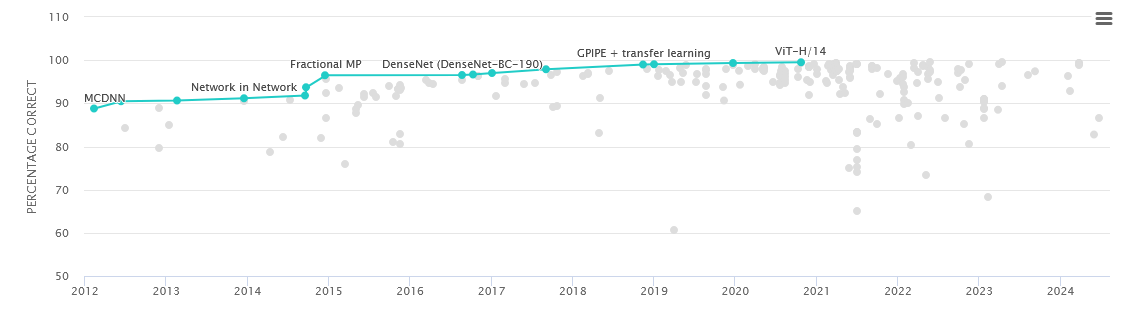

In [48]:
for result in results:
    print(result)

{'name': 'NN', 'accuracy': 48.25, 'epochs': 20, 'learning_rate': 0.001}
{'name': 'CNN', 'accuracy': 79.36, 'epochs': 20, 'learning_rate': 0.001}
{'name': 'dropout_CNN', 'accuracy': 68.53, 'epochs': 20, 'learning_rate': 0.001}
{'name': 'dropout_CNN', 'accuracy': 81.54, 'epochs': 50, 'learning_rate': 0.001}
{'name': 'dropout_batch_norm_CNN', 'accuracy': 82.01, 'epochs': 50, 'learning_rate': 0.001}
{'name': 'dropout_batch_norm_CNN', 'accuracy': 81.83, 'epochs': 50, 'learning_rate': 0.001}
{'name': 'dropout_batch_norm_CNN', 'accuracy': 82.35, 'epochs': 50, 'learning_rate': 0.001}
